In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, roc_auc_score
from keras.callbacks import TensorBoard
import shap
import joblib
import keras_tuner as kt

In [4]:
pip install --upgrade typing-extensions

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Using vaex to pre-process the large datasets
import vaex

In [4]:
df = pd.read_csv('Patient Survival Detection/Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [5]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [6]:
df.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [7]:
df['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [8]:
df[df['hospital_death'].isna()]

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem


In [9]:
df.isnull().sum()[df.isnull().sum() != 0]

age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 175, dtype: int64

In [10]:
df.isnull().mean()*100

encounter_id                   0.000000
patient_id                     0.000000
hospital_id                    0.000000
hospital_death                 0.000000
age                            4.610033
                                 ...   
leukemia                       0.779606
lymphoma                       0.779606
solid_tumor_with_metastasis    0.779606
apache_3j_bodysystem           1.812175
apache_2_bodysystem            1.812175
Length: 186, dtype: float64

In [11]:
# percentage of rows with missing values
df.isnull().any(axis=1).sum()/len(df.index)

0.99972741050887

In [12]:
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
91708    False
91709    False
91710    False
91711    False
91712    False
Length: 91713, dtype: bool

In [14]:
# loading dataframe using vaex
ndf = vaex.from_csv_arrow('Patient Survival Detection/Dataset.csv')
ndf.info()

column,type,unit,description,expression
encounter_id,int64,,,
patient_id,int64,,,
hospital_id,int64,,,
hospital_death,int64,,,
age,int64,,,
bmi,float64,,,
elective_surgery,int64,,,
ethnicity,str,,,
gender,str,,,
height,float64,,,


1. Filtering subdataset to select key columns
2. Remove vitamins columns to reduce dataset

In [15]:
kdf = df.iloc[:,:19]
kdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   encounter_id           91713 non-null  int64  
 1   patient_id             91713 non-null  int64  
 2   hospital_id            91713 non-null  int64  
 3   hospital_death         91713 non-null  int64  
 4   age                    87485 non-null  float64
 5   bmi                    88284 non-null  float64
 6   elective_surgery       91713 non-null  int64  
 7   ethnicity              90318 non-null  object 
 8   gender                 91688 non-null  object 
 9   height                 90379 non-null  float64
 10  hospital_admit_source  70304 non-null  object 
 11  icu_admit_source       91601 non-null  object 
 12  icu_id                 91713 non-null  int64  
 13  icu_stay_type          91713 non-null  object 
 14  icu_type               91713 non-null  object 
 15  pr

In [16]:
fdf = pd.concat([kdf, df[['aids','diabetes_mellitus']]], axis=1)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   encounter_id           91713 non-null  int64  
 1   patient_id             91713 non-null  int64  
 2   hospital_id            91713 non-null  int64  
 3   hospital_death         91713 non-null  int64  
 4   age                    87485 non-null  float64
 5   bmi                    88284 non-null  float64
 6   elective_surgery       91713 non-null  int64  
 7   ethnicity              90318 non-null  object 
 8   gender                 91688 non-null  object 
 9   height                 90379 non-null  float64
 10  hospital_admit_source  70304 non-null  object 
 11  icu_admit_source       91601 non-null  object 
 12  icu_id                 91713 non-null  int64  
 13  icu_stay_type          91713 non-null  object 
 14  icu_type               91713 non-null  object 
 15  pr

> Removing redundant columns from the dataset

In [17]:
mdf = fdf.drop(['encounter_id','patient_id','readmission_status'], axis=1)
target = fdf['hospital_death']

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


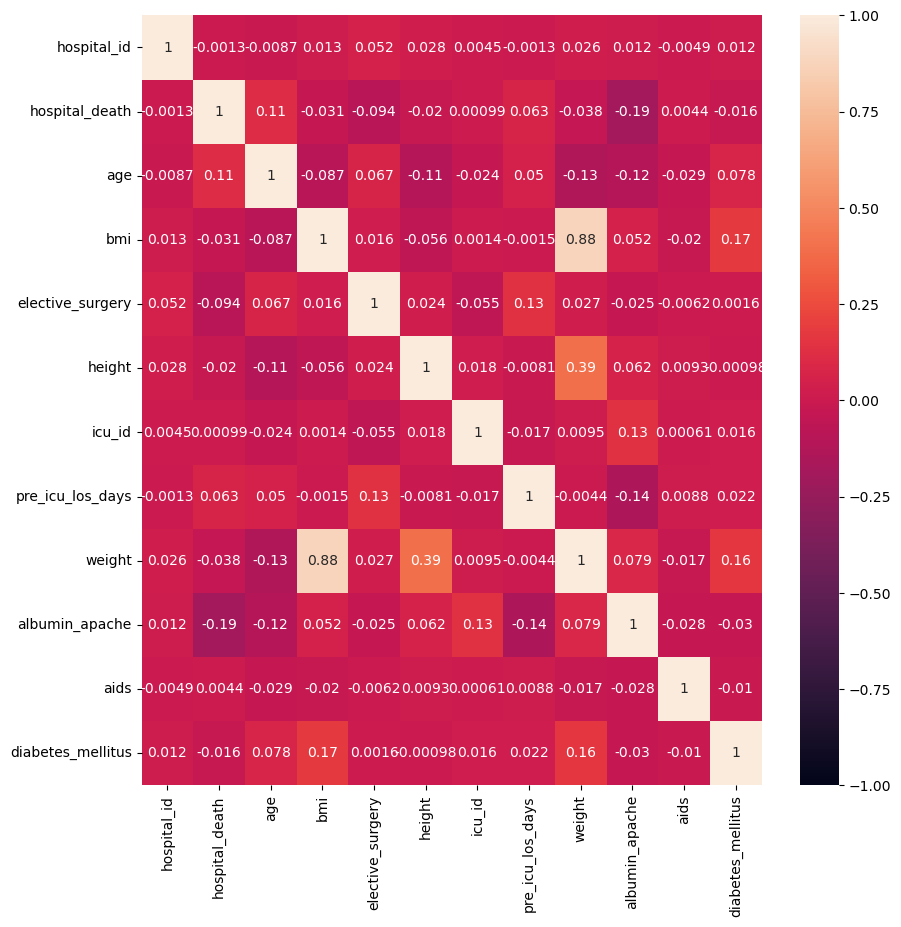

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(mdf.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

> Handling missing values

In [19]:
# let's check the albumin missing values
mdf['albumin_apache'].isnull().sum()/len(mdf['albumin_apache'])

0.5929257575261958

In [20]:
mdf['age']= mdf['age'].fillna(mdf['age'].mean())
mdf['bmi']= mdf['bmi'].fillna(mdf['bmi'].mean())
mdf['height']= mdf['height'].fillna(mdf['height'].mean())
mdf['weight'].fillna(mdf['weight'].mean(), inplace=True)

In [21]:
# handling missing values by most recurring values
mdf['hospital_admit_source'].replace(np.nan, 'Emergency Department', inplace=True)
mdf['icu_admit_source'].replace(np.nan,'Accident & Emergency', inplace=True)
mdf.drop('albumin_apache', axis=1, inplace=True)

In [22]:
# drop all the rows with missing values 
mdf.dropna(inplace=True, axis=0)
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89596 entries, 0 to 91712
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hospital_id            89596 non-null  int64  
 1   hospital_death         89596 non-null  int64  
 2   age                    89596 non-null  float64
 3   bmi                    89596 non-null  float64
 4   elective_surgery       89596 non-null  int64  
 5   ethnicity              89596 non-null  object 
 6   gender                 89596 non-null  object 
 7   height                 89596 non-null  float64
 8   hospital_admit_source  89596 non-null  object 
 9   icu_admit_source       89596 non-null  object 
 10  icu_id                 89596 non-null  int64  
 11  icu_stay_type          89596 non-null  object 
 12  icu_type               89596 non-null  object 
 13  pre_icu_los_days       89596 non-null  float64
 14  weight                 89596 non-null  float64
 15  ai

# EDA

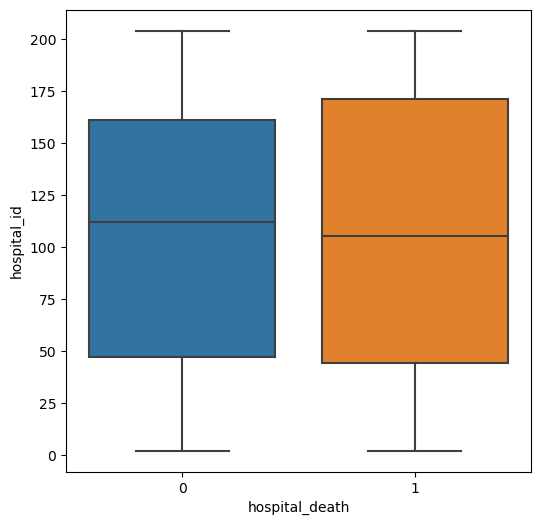

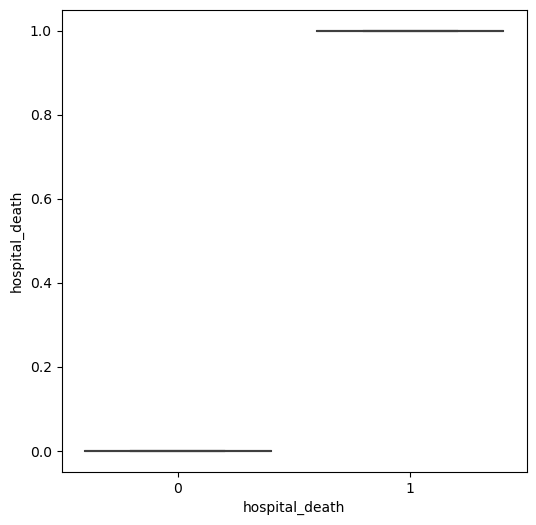

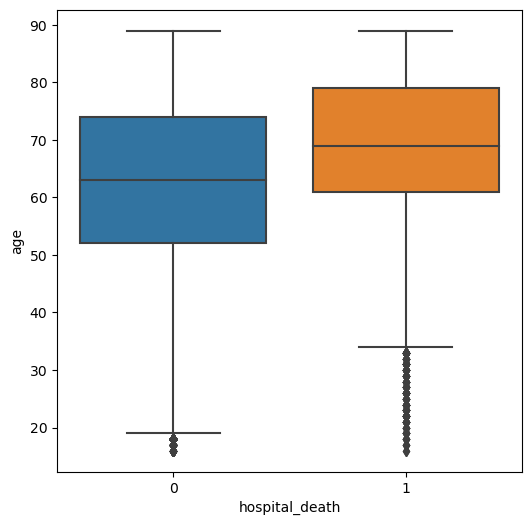

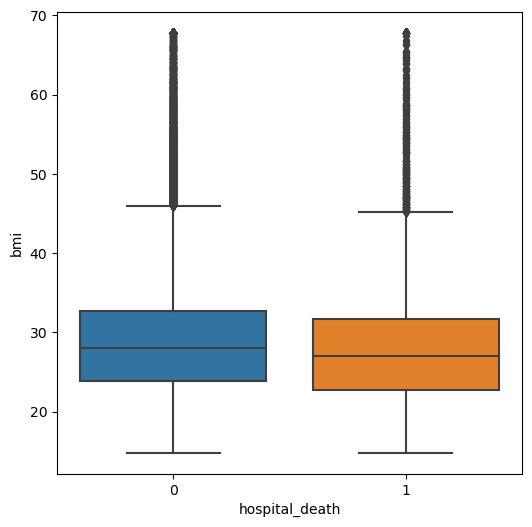

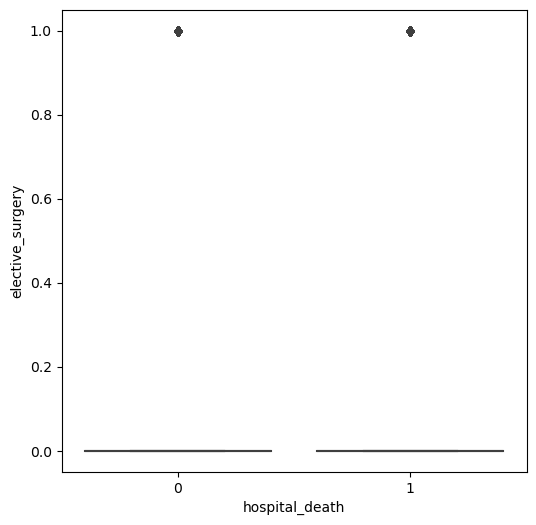

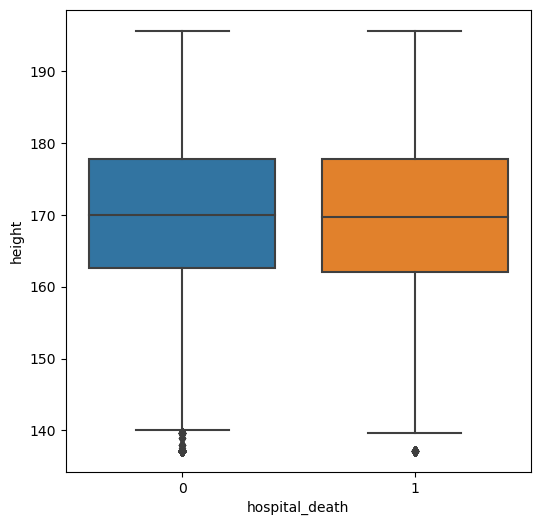

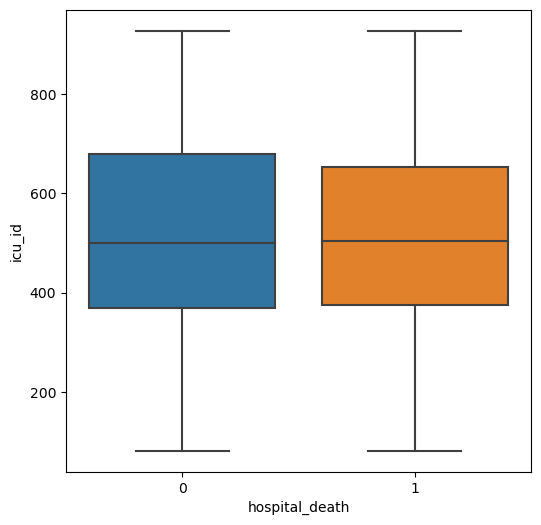

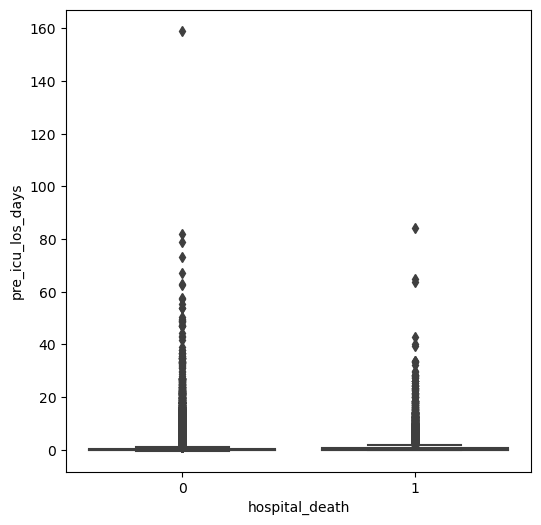

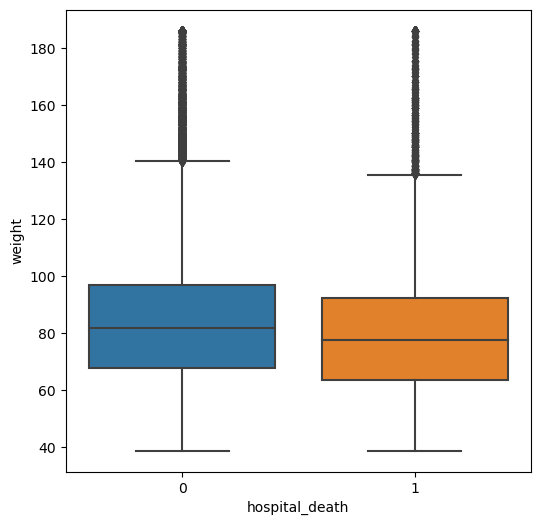

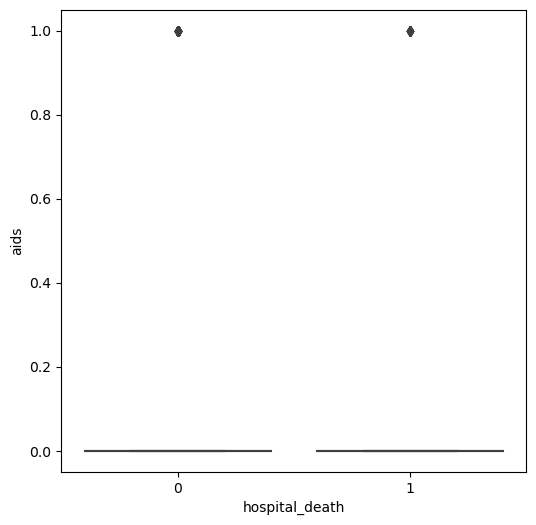

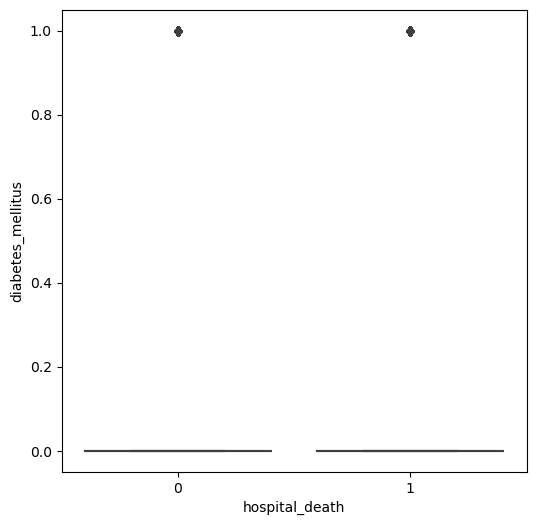

In [23]:
for i, col in enumerate(list(mdf.dtypes[mdf.dtypes != 'object'].index)):
    plt.figure(figsize=(6,6))
    sns.boxplot(x='hospital_death', y=col, data=mdf)
    plt.show()

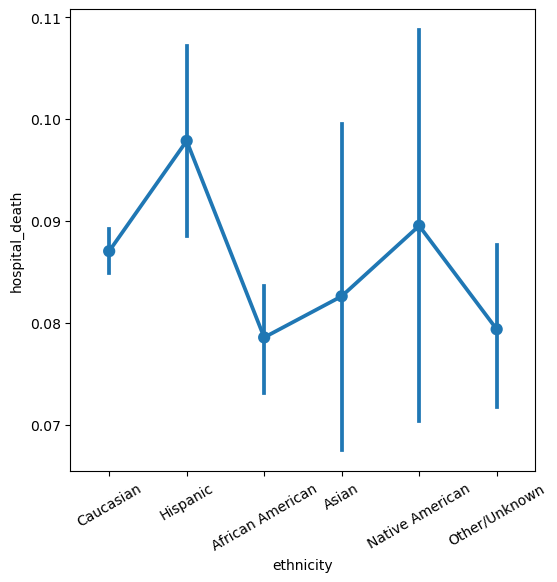

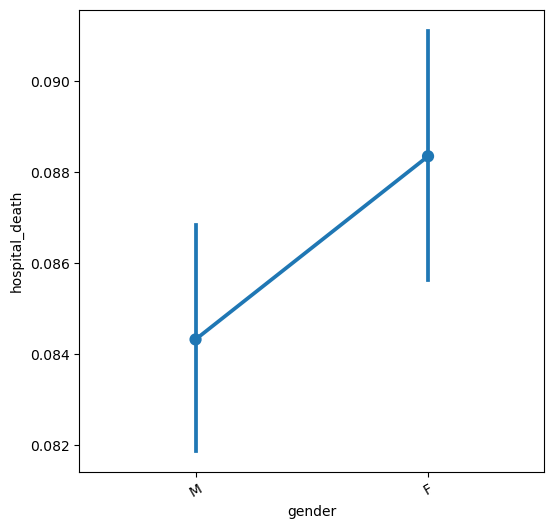

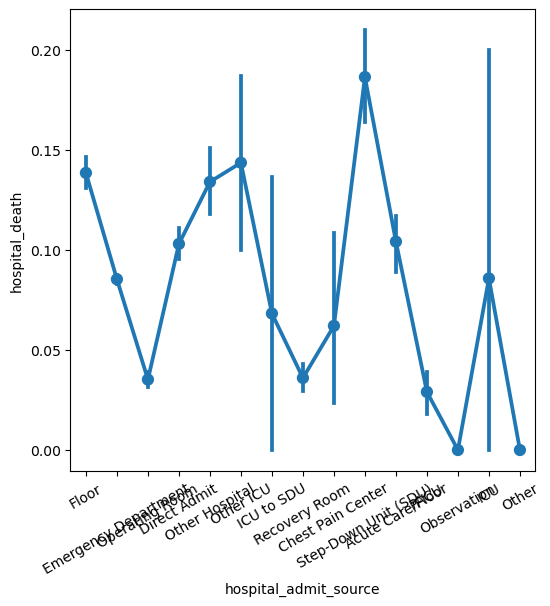

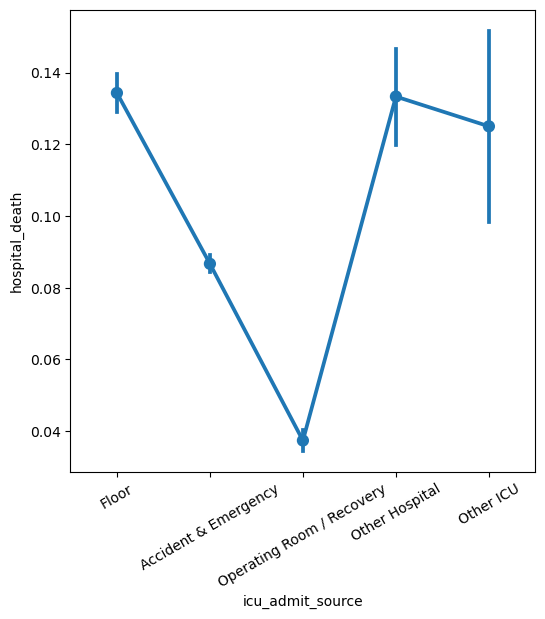

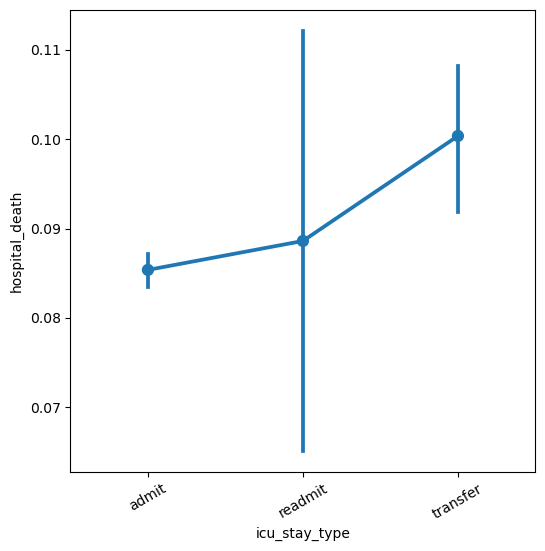

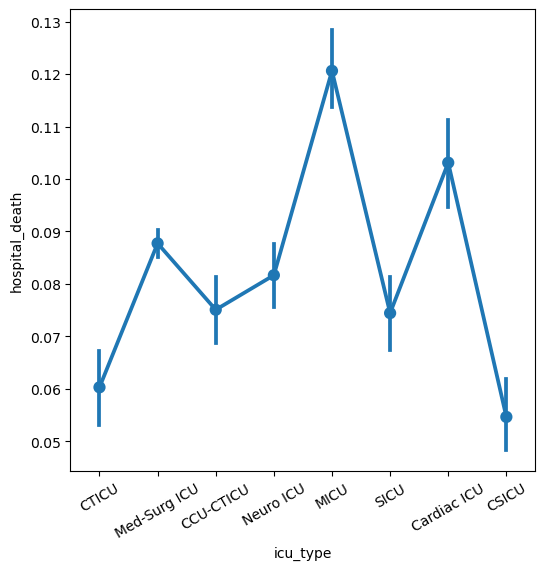

In [24]:
for col in list(mdf.dtypes[mdf.dtypes == 'object'].index):
    plt.figure(figsize=(6,6))
    sns.pointplot(y='hospital_death', x=col, data=mdf)
    plt.xticks(rotation=30)
    plt.show()

# Conclusions:
1. Numerical columns are not indicative of target columns
2. Categorical columns represent target variable more than numerical columns

# Next steps:
1. Feature encoding
2. Imbalance data treatment
3. Select KBest features
4. Feature scaling/transformation
5. NN modeling

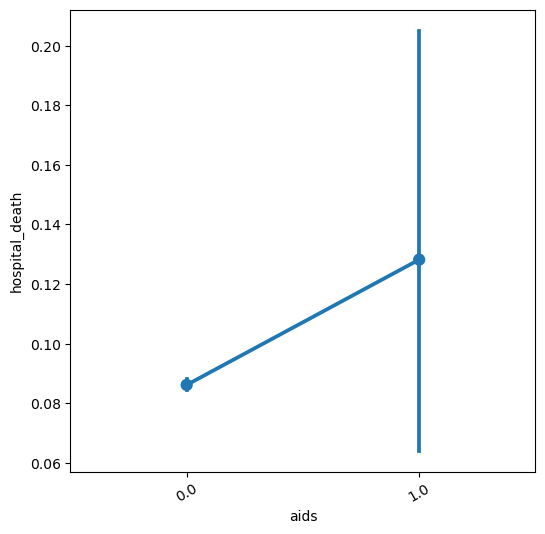

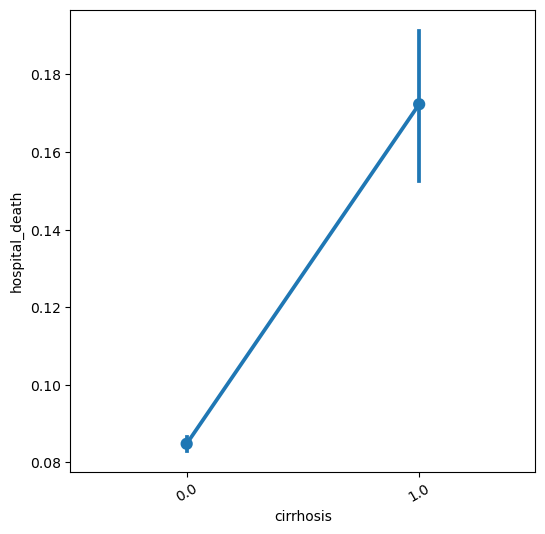

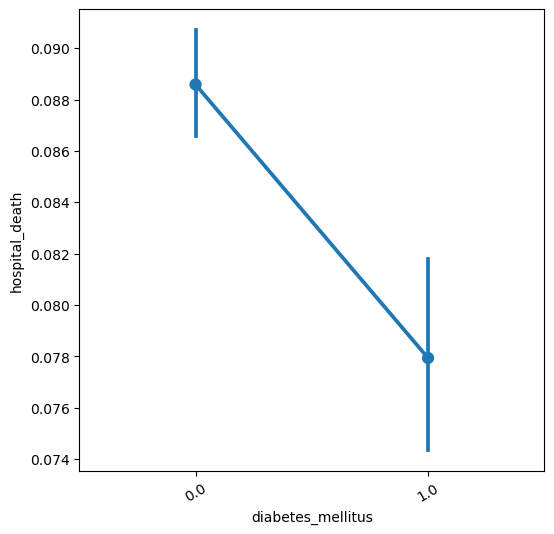

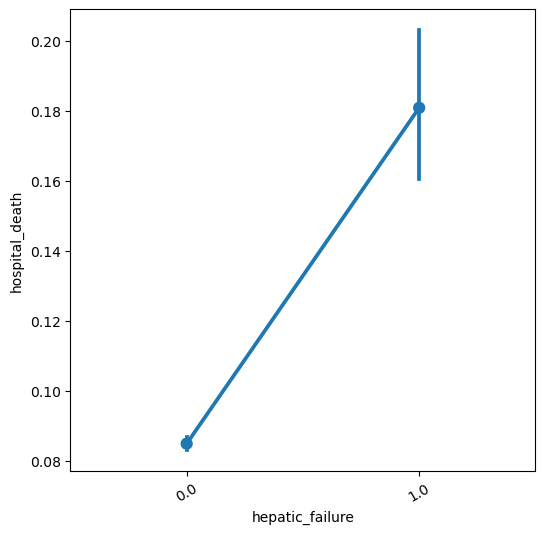

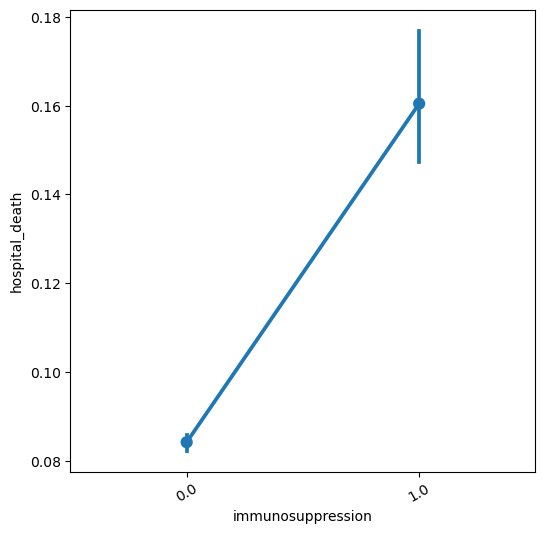

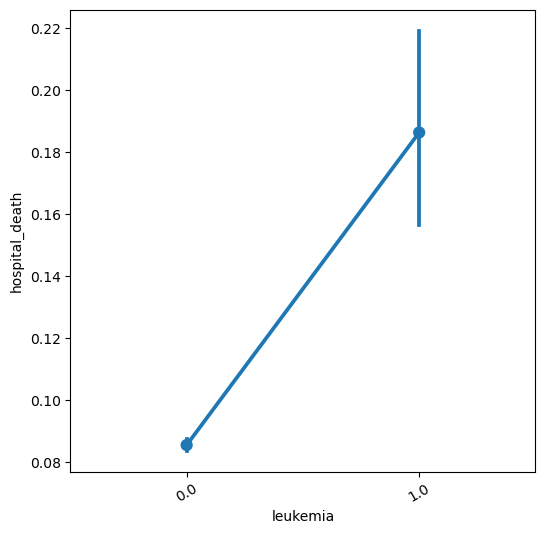

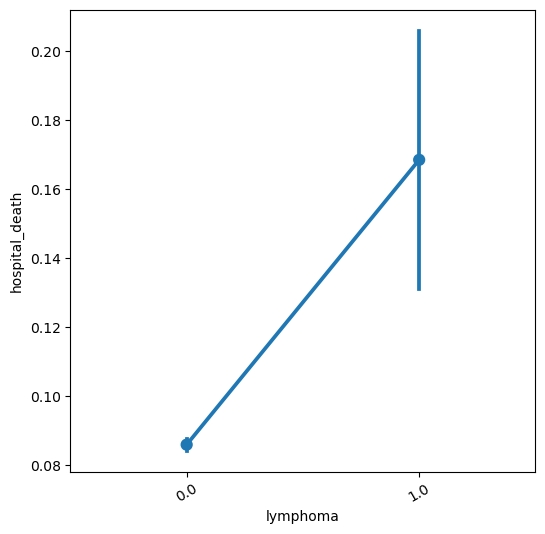

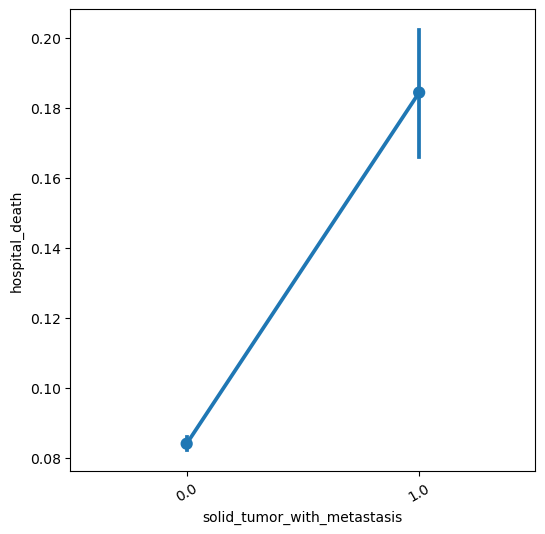

In [25]:
# check out aids to tumor columns for death cases
ldf = df.loc[:,'aids':'solid_tumor_with_metastasis']
for col in list(ldf.columns):
    plt.figure(figsize=(6,6))
    sns.pointplot(y=mdf['hospital_death'], x=col, data=ldf)
    plt.xticks(rotation=30)
    plt.show()

In [26]:
# final dataframe to append to mdf
cleand_ldf = ldf.dropna(axis=0)

In [27]:
# merge mdf and cleand_ldf on common indices
new_df = mdf.join(cleand_ldf, on=mdf.index, lsuffix='mdf', rsuffix='ldf')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89596 entries, 0 to 91712
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hospital_id                  89596 non-null  int64  
 1   hospital_death               89596 non-null  int64  
 2   age                          89596 non-null  float64
 3   bmi                          89596 non-null  float64
 4   elective_surgery             89596 non-null  int64  
 5   ethnicity                    89596 non-null  object 
 6   gender                       89596 non-null  object 
 7   height                       89596 non-null  float64
 8   hospital_admit_source        89596 non-null  object 
 9   icu_admit_source             89596 non-null  object 
 10  icu_id                       89596 non-null  int64  
 11  icu_stay_type                89596 non-null  object 
 12  icu_type                     89596 non-null  object 
 13  pre_icu_los_days

> Encoding categorical columns

In [28]:
X_new = new_df.drop('hospital_death', axis=1)
tar = new_df['hospital_death']

In [29]:
X_new = X_new.reset_index()
X_new_rein = X_new.drop('index', axis=1)

In [30]:
columns = ['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type']

encoder = OrdinalEncoder()
encoder.fit(X_new_rein[columns])
encoded_X = encoder.transform(X_new_rein[columns])
encoded_df = pd.DataFrame(encoded_X, columns=X_new_rein[columns].columns, index=X_new_rein.index)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89596 entries, 0 to 89595
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ethnicity              89596 non-null  float64
 1   gender                 89596 non-null  float64
 2   hospital_admit_source  89596 non-null  float64
 3   icu_admit_source       89596 non-null  float64
 4   icu_stay_type          89596 non-null  float64
 5   icu_type               89596 non-null  float64
dtypes: float64(6)
memory usage: 4.1 MB


In [31]:
encoder.categories_

[array(['African American', 'Asian', 'Caucasian', 'Hispanic',
        'Native American', 'Other/Unknown'], dtype=object),
 array(['F', 'M'], dtype=object),
 array(['Acute Care/Floor', 'Chest Pain Center', 'Direct Admit',
        'Emergency Department', 'Floor', 'ICU', 'ICU to SDU',
        'Observation', 'Operating Room', 'Other', 'Other Hospital',
        'Other ICU', 'PACU', 'Recovery Room', 'Step-Down Unit (SDU)'],
       dtype=object),
 array(['Accident & Emergency', 'Floor', 'Operating Room / Recovery',
        'Other Hospital', 'Other ICU'], dtype=object),
 array(['admit', 'readmit', 'transfer'], dtype=object),
 array(['CCU-CTICU', 'CSICU', 'CTICU', 'Cardiac ICU', 'MICU',
        'Med-Surg ICU', 'Neuro ICU', 'SICU'], dtype=object)]

In [35]:
a = 'Floor'
b = 'Floor'
inpt_arr = np.array(['Asian','F',a,b,'admit','SICU']).reshape(1,-1)
print(inpt_arr)

[['Asian' 'F' 'Floor' 'Floor' 'admit' 'SICU']]


In [36]:
std_arr = encoder.transform(inpt_arr.reshape(1,-1))

X does not have valid feature names, but OrdinalEncoder was fitted with feature names


In [37]:
joblib.dump(encoder, "ord_encoder.joblib")

['ord_encoder.joblib']

In [38]:
X_new_rein[columns] = encoded_df
# FINAL DATAFRAME FOR FURTHER data balancing and modeling 
#X_nn = X_new_rein.drop('level_0', axis=1)
X_new_rein.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89596 entries, 0 to 89595
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hospital_id                  89596 non-null  int64  
 1   age                          89596 non-null  float64
 2   bmi                          89596 non-null  float64
 3   elective_surgery             89596 non-null  int64  
 4   ethnicity                    89596 non-null  float64
 5   gender                       89596 non-null  float64
 6   height                       89596 non-null  float64
 7   hospital_admit_source        89596 non-null  float64
 8   icu_admit_source             89596 non-null  float64
 9   icu_id                       89596 non-null  int64  
 10  icu_stay_type                89596 non-null  float64
 11  icu_type                     89596 non-null  float64
 12  pre_icu_los_days             89596 non-null  float64
 13  weight          

In [39]:
X_new_rein[['hospital_admit_source','icu_admit_source']]

,hospital_admit_source,icu_admit_source
0,4.0,1.0
1,4.0,1.0
2,3.0,0.0
3,8.0,2.0
4,3.0,0.0
...,...,...
89591,0.0,1.0
89592,3.0,1.0
89593,3.0,0.0
89594,3.0,0.0


In [40]:
# change the indices of the target variable
tar.index = X_new_rein.index

# Upsampling to balance the dataset

In [41]:
# smote upsampling and feature selection, then modeling
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_res ,y_res = smote.fit_resample(X_new_rein, tar)

# Feature selection function

In [42]:
def feature_sel(method, features):
    if method==f_classif:
        fse = SelectKBest(f_classif, k=features)
        X_ne = fse.fit_transform(X_res,y_res)
    if method==chi2:
        fse = SelectKBest(chi2, k=features)
        X_ne = fse.fit_transform(X_res,y_res)
    return pd.DataFrame(X_ne, columns = fse.get_feature_names_out())

In [43]:
X_ne = feature_sel(f_classif,10)
X_ne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163750 entries, 0 to 163749
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          163750 non-null  float64
 1   elective_surgery             163750 non-null  float64
 2   hospital_admit_source        163750 non-null  float64
 3   icu_admit_source             163750 non-null  float64
 4   pre_icu_los_days             163750 non-null  float64
 5   weight                       163750 non-null  float64
 6   cirrhosis                    163750 non-null  float64
 7   hepatic_failure              163750 non-null  float64
 8   immunosuppression            163750 non-null  float64
 9   solid_tumor_with_metastasis  163750 non-null  float64
dtypes: float64(10)
memory usage: 12.5 MB


# Modeling using NNs

In [45]:
# standardize the dataset
scaler = StandardScaler()
X_fi = scaler.fit_transform(X_ne)
X_fi = pd.DataFrame(X_fi, columns=X_ne.columns)

In [46]:
pred_values = list(scaler.transform(np.array([20,0,4,1,5,50,0,1,0,1]).reshape(1,-1)).ravel())

X does not have valid feature names, but StandardScaler was fitted with feature names


In [47]:
joblib.dump(scaler, "std_scaler.joblib")

['std_scaler.joblib']

In [48]:
# train and test split
X_trn, X_tst, y_trn, y_tst = train_test_split(X_fi, y_res, test_size=0.25, random_state=42)

In [49]:
# NN
model = Sequential()
model.add(Dense(128, input_dim=10, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 3

In [50]:
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Tensorboard Visualization

In [51]:
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

history = model.fit(X_trn, y_trn, validation_data=(X_tst, y_tst), epochs=50,batch_size=128)

Epoch 1/50
960/960 [==============================] - 7s 6ms/step - loss: 0.6552 - accuracy: 0.6285 - val_loss: 0.6064 - val_accuracy: 0.6727
Epoch 2/50
960/960 [==============================] - 5s 5ms/step - loss: 0.5991 - accuracy: 0.6733 - val_loss: 0.5840 - val_accuracy: 0.6832
Epoch 3/50
960/960 [==============================] - 4s 5ms/step - loss: 0.5845 - accuracy: 0.6846 - val_loss: 0.5738 - val_accuracy: 0.6929
Epoch 4/50
960/960 [==============================] - 5s 5ms/step - loss: 0.5752 - accuracy: 0.6904 - val_loss: 0.5694 - val_accuracy: 0.6872
Epoch 5/50
960/960 [==============================] - 5s 5ms/step - loss: 0.5681 - accuracy: 0.6953 - val_loss: 0.5600 - val_accuracy: 0.7042
Epoch 6/50
960/960 [==============================] - 5s 5ms/step - loss: 0.5605 - accuracy: 0.7001 - val_loss: 0.5516 - val_accuracy: 0.7064
Epoch 7/50
960/960 [==============================] - 5s 5ms/step - loss: 0.5529 - accuracy: 0.7018 - val_loss: 0.5438 - val_accuracy: 0.7140
Epoch 

In [52]:
preds = model.predict(X_tst)
pred = list()
for i in range(len(preds)):
    pred.append(np.argmax(preds[i]))
acc = accuracy_score(y_tst, pred)
roc_auc = roc_auc_score(y_tst, pred)
print("Accuracy score:", acc)
print("ROC AUC score:", roc_auc)

1280/1280 [==============================] - 3s 2ms/step
Accuracy score: 0.49670233035321704
ROC AUC score: 0.5


# XAI (Kernel Explainer)

In [53]:
shap.initjs()

In [54]:
#def f(X):
#    return model.predict(X).flatten()

#explainer = shap.KernelExplainer(f, X_tst.iloc[:200,:])
#shap_values = explainer.shap_values(X_tst.iloc[:200,:])

In [55]:
#shap_value = explainer.shap_values(X_tst.iloc[90,:])
#shap.force_plot(explainer.expected_value, shap_value, X_tst.iloc[90,:])

In [56]:
X_tst.iloc[90,:]

age                            0.192150
elective_surgery              -0.342198
hospital_admit_source         -0.383443
icu_admit_source               0.433340
pre_icu_los_days               0.093395
weight                        -0.406398
cirrhosis                     -0.172631
hepatic_failure               -0.159538
immunosuppression             -0.217897
solid_tumor_with_metastasis   -0.201705
Name: 16686, dtype: float64

# Save the model artifact

In [57]:
#joblib.dump(explainer, "explainer.joblib")

# Keras Tuner

In [58]:
# define a modeling function
def model_func(hp):
    model = Sequential()
    # hyper parameters optimization on units
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')]

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)

    return model

In [59]:
# setting tuner instances
tuner = kt.RandomSearch(
    model_func,
    objective='val_loss',
    max_trials=5)

In [60]:
# early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5)

In [61]:
# tuning hyper parameters using keras tuner
tuner.search(X_trn, y_trn, epochs=30, validation_data = (X_tst, y_tst), callbacks=[stop_early])

# getting best hyper parameters 
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 04m 07s]
val_loss: 0.4146071970462799

Best val_loss So Far: 0.4146071970462799
Total elapsed time: 00h 20m 50s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.001.



# Final model using tuned parameters

In [62]:
# model instance
model = Sequential()
model.add(keras.layers.Dense(units=448, activation='relu'))
model.add(keras.layers.Dense(units=448, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')]

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)

history2 = model.fit(X_trn, y_trn, epochs=30, batch_size=128, validation_data=(X_tst, y_tst),
                     callbacks=[stop_early])

Epoch 1/30
960/960 [==============================] - 13s 12ms/step - loss: 0.5389 - precision: 0.7013 - recall: 0.7014 - auc_1: 0.7924 - val_loss: 0.5121 - val_precision: 0.8219 - val_recall: 0.5598 - val_auc_1: 0.8158
Epoch 2/30
960/960 [==============================] - 10s 10ms/step - loss: 0.4820 - precision: 0.7665 - recall: 0.6634 - auc_1: 0.8279 - val_loss: 0.4792 - val_precision: 0.8701 - val_recall: 0.5551 - val_auc_1: 0.8346
Epoch 3/30
960/960 [==============================] - 10s 11ms/step - loss: 0.4660 - precision: 0.7837 - recall: 0.6577 - auc_1: 0.8368 - val_loss: 0.4592 - val_precision: 0.8053 - val_recall: 0.6471 - val_auc_1: 0.8421
Epoch 4/30
960/960 [==============================] - 10s 10ms/step - loss: 0.4587 - precision: 0.7949 - recall: 0.6596 - auc_1: 0.8415 - val_loss: 0.4506 - val_precision: 0.7418 - val_recall: 0.7559 - val_auc_1: 0.8500
Epoch 5/30
960/960 [==============================] - 10s 10ms/step - loss: 0.4509 - precision: 0.8042 - recall: 0.6622 

In [63]:
model.save("patients_pred_model.h5")

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [64]:
list(model.predict(np.array(pred_values).reshape(1,-1))[0])[0]

1/1 [==============================] - 0s 88ms/step


0.17514555